In [321]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
import json
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
from pandas.io.json import json_normalize
from IPython.display import display
from pandas import HDFStore,DataFrame
import pandas as pd

%matplotlib inline 
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

<h2>Following cells to retrieve job indexes from ES</h2>

In [322]:
#define function to filter on time
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        #print(day)
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days < last_days:
            filtered.append(i.rstrip())
    return filtered

In [323]:
#get job archive indices from ES
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
if 'jobs_archive_2016_status' in indices:
    indices.remove('jobs_archive_2016_status')
#remove data due to central problem
if 'jobs_archive_2016-12-29' in indices:
    indices.remove('jobs_archive_2016-12-29')
#print(indices)

<h2>Following cells to retrieve job info from ES</h2>

In [336]:
#define function to create jobs object from scroll
def jobs_list(scroll, max=-1):
  
    i = 0   
    jobs = []
    
    for result in scroll:
        #print(result['_source']['pandaid'])
        #print_info(result)
        if (max<0):
            jobs.append(result)
        else:
            if (i<max):
                jobs.append(result)
        #if i<1: print_info(result)
        i = i+1
        if not i%10000:  
            print('processing hit '+str(i)+'...')

    return jobs

In [337]:
# use e.g. last_days=7 or pattern='2016-02' (no wildcard !)
NDAYS=1  #NDAYS=150 #NDAYS=''
PATTERN='' #PATTERN = '2016-03' #PATTERN=''
ind = time_filter(indices, last_days=NDAYS, pattern=PATTERN)
ind = ','.join(ind)
print(ind)

jobs_archive_2017-04-13


In [351]:
#select finished analysis jobs with inputfile DAOD
query = "(prodsourcelabel:user) AND (NOT produsername:gangarbt) AND (NOT processingtype:pmerge) AND (jobstatus:finished) AND inputfiletype:DAOD*"

#count hits
#count =(es.count(index=ind, q=query, request_timeout=600))
#print('hits: '+str(count['count']))

#test query with search -> gets only a limited number of records (size=x). Cannot be used for big searches x>10000
#res = es.search(index=ind, q=query, size = 2, request_timeout=600, _source=["computingsite", "pandaid", "jeditaskid", "inputfileproject","inputfiletype","produsername", "proddblock"])
#jobs = res['hits']['hits']
    
#use scroll to get all hits (allows unlimited result queries)
scroll = scan(es, index=ind, q=query, scroll='5m', timeout="5m", size=100, _source=["computingsite", "pandaid", "jeditaskid", "inputfileproject","inputfiletype","produsername", "proddblock"])

#jobs = jobs_list(scroll, 10000)
jobs = jobs_list(scroll)

#save into Panda Dataframe
print('Saving into Panda Dataframe')
df_orig = json_normalize(jobs)
print(df.columns)

processing hit 10000...
processing hit 20000...
processing hit 30000...
processing hit 40000...
processing hit 50000...
processing hit 60000...
processing hit 70000...
processing hit 80000...
processing hit 90000...
processing hit 100000...
processing hit 110000...
processing hit 120000...
processing hit 130000...
processing hit 140000...
processing hit 150000...
processing hit 160000...
Saving into Panda Dataframe
Index(['date', 'scope', 'type', 'taskid', 'pandaid', 'name', 'site', 'user'], dtype='object')


<h2>Re-arrange jobs info on original DF</h2>

In [354]:
#save only interesting columns
df = df_orig[['_index', '_source.inputfileproject', '_source.inputfiletype', '_source.jeditaskid', '_source.pandaid', 
         '_source.proddblock', '_source.computingsite', '_source.produsername']] #'_source.computingsite',

#change name and manipulate strings
df = df.rename(index=str, columns={"_index": "date", "_source.inputfileproject": "scope",
         "_source.inputfiletype":"type", "_source.jeditaskid":"taskid", "_source.pandaid":"pandaid", 
         "_source.proddblock":"name", "_source.computingsite":"site", "_source.produsername":"user"})

df['date'] = df['date'].str.replace('jobs_archive_', '')
df['name'] = df['name'].str.split(':').str.get(1)

#display(df.head(10))
#display(df['date'][0])

#save the date
DATE=df['date'][0]

#DEBUG: number of accesses per dataset per different users
#df_accesses = df.groupby('name')['user'].nunique().reset_index()
#df_accesses.plot('name')
#display(df_accesses.loc[df_accesses['user'] >1])

#type(df)
print("Original DF")
display(df.columns)
display(df.shape)

Original DF


Index(['date', 'scope', 'type', 'taskid', 'pandaid', 'name', 'site', 'user'], dtype='object')

(164517, 8)

<h2>Re-arrange datasets as a function of user accesses</h2>

Accesses per unique name and user, summed over pandaid


(3161, 6)

Sum over pandaid must match original DF


164517

,name,date,type,scope,user,pandaid
2723,mc15_13TeV.410000.PowhegPythiaEvtGen_P2012_ttb...,2017-04-13,DAOD_TOPQ1,mc15_13TeV,3,28
586,data16_13TeV.00304128.physics_Main.merge.DAOD_...,2017-04-13,DAOD_MUON1,data16_13TeV,3,30
407,data16_13TeV.00302380.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,255
443,data16_13TeV.00302919.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,153
441,data16_13TeV.00302872.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,965
439,data16_13TeV.00302872.physics_Main.merge.DAOD_...,2017-04-13,DAOD_JETM6,data16_13TeV,2,375
433,data16_13TeV.00302831.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,47
1229,mc15_13TeV.307480.Sherpa_221_NNPDF30NNLO_ttbar...,2017-04-13,DAOD_HIGG4D2,mc15_13TeV,2,4
425,data16_13TeV.00302737.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,181
418,data16_13TeV.00302393.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,2,370


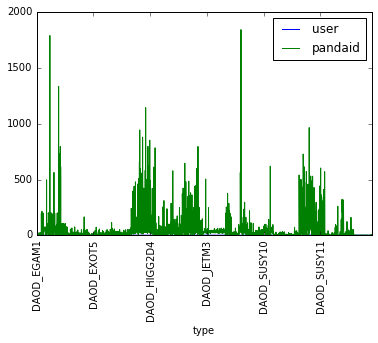

Accesses per unique name (summed over pandaid and users)


(2951, 6)

Sum over pandaid must match original DF


164517

In [355]:
#create number of accesses per pandaid -> get rid of site
df_pandaid = df.groupby(['name', 'date', 'type', 'scope', 'user'])['pandaid'].nunique().reset_index()

print("Accesses per unique name and user, summed over pandaid")
display(df_pandaid.shape)
print("Sum over pandaid must match original DF")
display(df_pandaid['pandaid'].sum())
#display(df_pandaid.head(10))

#df_pandaid.plot('user')
#df_pandaid.plot('name')

#create number of accesses per unique user, sum over pandaid
df_user = df_pandaid.groupby(['name','date', 'type','scope']).agg({"pandaid": np.sum, "user": pd.Series.nunique}).reset_index()
display(df_user.sort_values('user',ascending=False).head(10))

df_user.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.show()

print("Accesses per unique name (summed over pandaid and users)")
display(df_user.shape)
print("Sum over pandaid must match original DF")
df_user.pandaid.sum()

#debug
#df_more=df_user.loc[df_user['user'] >1]
#display(df_more)
#df_more['name'][181]
#df_debug=df.loc[df['name']==df_more['name'][181]]
#display(df_debug)


<h2>Re-arrange datasets as a function of accessed replicas</h2>

Accesses per unique name and site, summed over pandaid


(4572, 6)

Sum over pandaid must match original DF


164517

,name,date,type,scope,pandaid,site
407,data16_13TeV.00302380.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,255,6
1107,data16_13TeV.00311402.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,351,6
305,data16_13TeV.00300487.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,226,6
708,data16_13TeV.00305920.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,305,6
1660,mc15_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTE...,2017-04-13,DAOD_STDM3,mc15_13TeV,1843,6
445,data16_13TeV.00302925.physics_Main.merge.DAOD_...,2017-04-13,DAOD_HIGG2D4,data16_13TeV,198,6
512,data16_13TeV.00303499.physics_Main.merge.DAOD_...,2017-04-13,DAOD_JETM3,data16_13TeV,53,5
2931,mc15_13TeV.410501.PowhegPythia8EvtGen_A14_ttba...,2017-04-13,DAOD_TOPQ1,mc15_13TeV,274,5
441,data16_13TeV.00302872.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,965,5
479,data16_13TeV.00303208.physics_Main.merge.DAOD_...,2017-04-13,DAOD_SUSY11,data16_13TeV,531,5


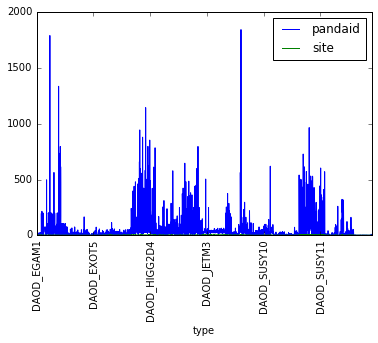

Accesses per unique name (summed over pandaid and sites)


(2951, 6)

Sum over pandaid must match original DF


164517

In [356]:
#create number of accesses per pandaid -> get rid of user
df_pandaid = df.groupby(['name', 'date', 'type', 'scope', 'site'])['pandaid'].nunique().reset_index()

print("Accesses per unique name and site, summed over pandaid")
display(df_pandaid.shape)
print("Sum over pandaid must match original DF")
display(df_pandaid['pandaid'].sum())
#display(df_pandaid.head(10))

#df_pandaid.plot('site')
#df_pandaid.plot('name')

#create number of accesses per unique site, sum over pandaid
df_site = df_pandaid.groupby(['name','date', 'type','scope']).agg({"pandaid": np.sum, "site": pd.Series.nunique}).reset_index()
display(df_site.sort_values('site',ascending=False).head(10))

df_site.sort_values('type').plot('type')
plt.xticks(rotation=90)
plt.show()

print("Accesses per unique name (summed over pandaid and sites)")
display(df_site.shape)
print("Sum over pandaid must match original DF")
df_site.pandaid.sum()


In [357]:
store = HDFStore('store_'+DATE+'.h5')
store['df_site'] = df_site
store['df_user'] = df_user